# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя:

Дата выдачи: <span style="color:red">__3 марта 19:00__</span>.

Мягкий дедлайн: <span style="color:red">__17 марта 5:00__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2025`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`.

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [6]:
from google.colab import drive
drive.mount("/content/MyDrive")

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [7]:
pip install wandb

In [8]:
import wandb
wandb.login()

True

In [9]:
# wandb.login(relogin=True)

In [10]:
import os

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [11]:
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import random

In [12]:
!ls "/content/MyDrive/MyDrive/Colab Notebooks/mmp/people_data/"

test  test_mask  train	train_mask


In [13]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images

        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.

        transforms : some collection
            Sequence of transformations for images and masks.
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        self.image_names = sorted(os.listdir(images_dir))
        if target_dir:
            self.mask_names = sorted(os.listdir(target_dir))
        else:
            self.mask_names = None

    def __len__(self):
        # your code here
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask

        Returns
        -------
        (image, mask)
        """
        # your code here
        path_to_image = os.path.join(self.images_dir, self.image_names[idx])
        image = Image.open(path_to_image)
        if self.target_dir:
            path_to_mask = os.path.join(self.target_dir, self.mask_names[idx])
            mask = Image.open(path_to_mask)


        if self.transforms:
            for transform in self.transforms:
                image, mask = transform(image, mask)
        return image, mask

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

1. случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения
2. случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
3. случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
4. случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

Используйте разумные пределы для аугментаций. Одной из причин плохого обучения модели могут быть слишком сильные аугментации. Визуально убедитесь, что граничные случаи достаточно адекватны задаче.

Обратите внимание, что под вырезанием фрагмента подрузумевается вырезания части изображения из исходного, то есть вырезание какой-то части изображения (создание отверстий в изображении). Если после слоя вырезания размеры изображения поменялись, то вы неправильно реализовали модуль.

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [14]:
DATA_PATH = "/content/MyDrive/MyDrive/Colab Notebooks/mmp/people_data"

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    # transforms=transform,
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    # transforms=transform
)

In [15]:
len(test_dataset)
t, m = train_dataset[0]
t = np.array(t)
t.shape

(320, 240, 3)

Функция для отображения изображения:

In [16]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)

    axes[0].set_axis_off()
    axes[1].set_axis_off()

    fig.tight_layout()
    plt.show()

In [17]:
import random
import os
from PIL import Image, ImageEnhance
import numpy as np


def apply_random_transform(p):
    def decorator(func):
        def wrapper(self, img, mask):
            if random.random() < p:
                return func(self, img, mask)
            return img, mask
        return wrapper
    return decorator

class flip:
    def __init__(self):
        pass
    @apply_random_transform(p=0.6)
    def __call__(self, image, mask):
        return image.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)


class Cut:
    def __init__(self, patch_size=(20, 20), max_w=240, max_h=320):
        self.patch_size = patch_size
        self.max_w = max_w
        self.max_h = max_h

    @apply_random_transform(p=0.6)
    def __call__(self, image, mask):
        image_copy, mask_copy = np.array(image.copy()), np.array(mask.copy())
        x = random.randint(0, self.max_h - self.patch_size[0])
        y = random.randint(0, self.max_w - self.patch_size[1])
        image_copy[x : x + self.patch_size[0], y : y + self.patch_size[1], :].fill(0)
        mask_copy[x : x + self.patch_size[0], y : y + self.patch_size[1]].fill(0)
        image_copy = Image.fromarray(image_copy, 'RGB')
        mask_copy = Image.fromarray(mask_copy, 'L')
        return image_copy, mask_copy


class Brightness:
    def __init__(self, per_bright=None):
        if per_bright:
            self.per_bright = per_bright + 1
        else:
            self.per_bright = random.uniform(0.2, 1.7)

    @apply_random_transform(p=0.6)
    def __call__(self, image, mask):
        enhancer = ImageEnhance.Brightness(image)
        img_brighter = enhancer.enhance(self.per_bright)
        return img_brighter, mask


class Background:
    def __init__(self, backgrounds_dir=None):
        self.folder_names = sorted(os.listdir(backgrounds_dir))
        self.backgrounds_dir = backgrounds_dir
    @apply_random_transform(p=0.6)
    def __call__(self, image, mask):
        idx_random_folder = random.randint(0, len(self.folder_names) - 1)
        path_folder = os.path.join(self.backgrounds_dir, self.folder_names[idx_random_folder])
        num_images = len(os.listdir(path_folder))
        idx_image = random.randint(0, num_images - 1)
        path_image = os.path.join(path_folder, (os.listdir(path_folder))[idx_image])
        back = Image.open(path_image).copy().resize((240, 320))

        back = np.array(back)
        image, mask = np.array(image), np.array(mask)
        mask_np = np.where(mask > 127, 1, 0)

        for channel in range(image.shape[2]):
            back[:, :, channel] = np.where(mask_np == 1, image[:, :, channel], back[:, :, channel])
        return Image.fromarray(back, 'RGB'), Image.fromarray(mask, 'L')


class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, image, mask):
        return  transforms.ToTensor()(image), transforms.ToTensor()(mask)

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, image, mask):
        return transforms.Normalize(mean=self.mean, std=self.std)(image), mask
class Denormalize_batch:
    def __init__(self):
        pass
    def __call__(self, image):
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        mean = torch.Tensor(mean).view(1, 3, 1, 1).to(image.device)
        std = torch.Tensor(std).view(1, 3, 1, 1).to(image.device)
        res = image.detach().clone()
        res = (res * std + mean)
        return res


Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных. Необходимо проверить каждый модуль аугментации отдельно, в ином случае будут сниматься баллы.

**Важно:** Проверьте корректность работы модулей, действительно ли маска изображения корректна для изображения после аугментации.

## Проверка работы модулей

### Модуль flip

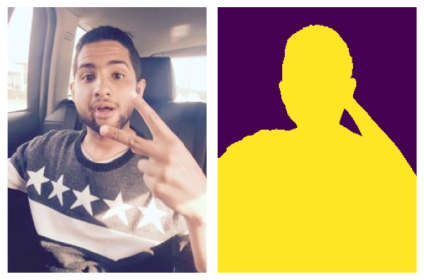

In [18]:
train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms = [
        flip(),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)
show_idx_image(train_dataset, 7)

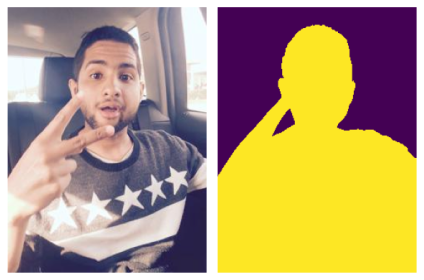

In [19]:
show_idx_image(train_dataset, 7)

### Модуль вырезания части фото

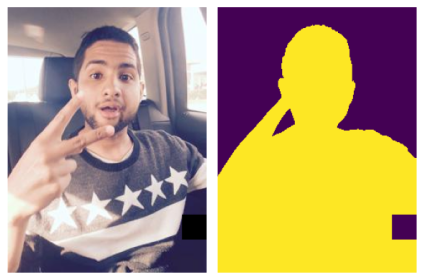

In [20]:
train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms = [
        Cut(patch_size=(30, 30)),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)
show_idx_image(train_dataset, 7)

### Модуль изменения яркости

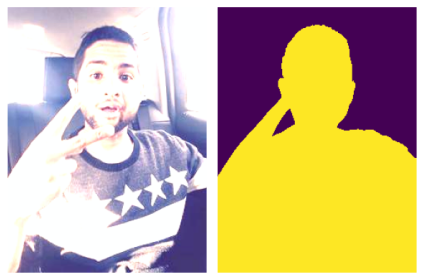

In [21]:
train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms = [
        Brightness(0.7),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)
show_idx_image(train_dataset, 7)

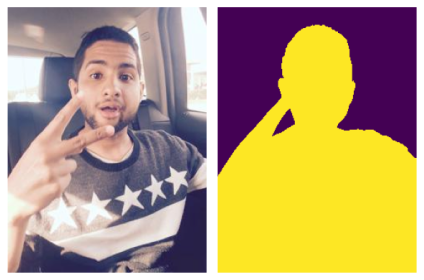

In [22]:
DATA_BACKGROUNDS = "/content/MyDrive/MyDrive/Colab Notebooks/mmp/background"
DATA_PATH = "/content/MyDrive/MyDrive/Colab Notebooks/mmp/people_data"
train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms = [
        Background(DATA_BACKGROUNDS),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)
show_idx_image(train_dataset, 7)

### Модуль изменения фона

In [23]:

transform = [
    flip(),
    Cut(),
    Brightness(0.7),
    Background(DATA_BACKGROUNDS),
    ToTensor(),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]


train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms = [
        flip(),
        Cut(),
        Brightness(0.7),
        Background(DATA_BACKGROUNDS),
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms = [
        ToTensor(),
        Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]
)

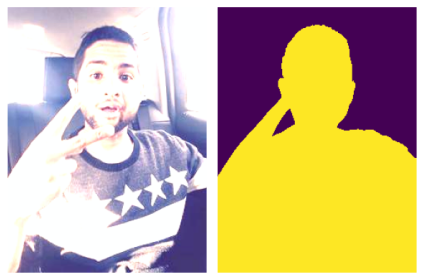

In [24]:
show_idx_image(train_dataset, 7)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$.

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [25]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits

    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)

        if self.with_logits:
            logits = torch.sigmoid(logits)

        h = 2 * torch.sum(logits * true_labels, dim=(-2, -1))
        l = torch.sum(logits + true_labels + self.eps, dim=(-2, -1))
        Dice = 1 - h / l
        if self.reduction == 'sum':
            loss_value = torch.sum(Dice)
        elif self.reduction == 'mean':
            loss_value = torch.mean(Dice)
        elif self.reduction is None:
            loss_value = Dice

        return loss_value

Проверка реализации:

In [22]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])
losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

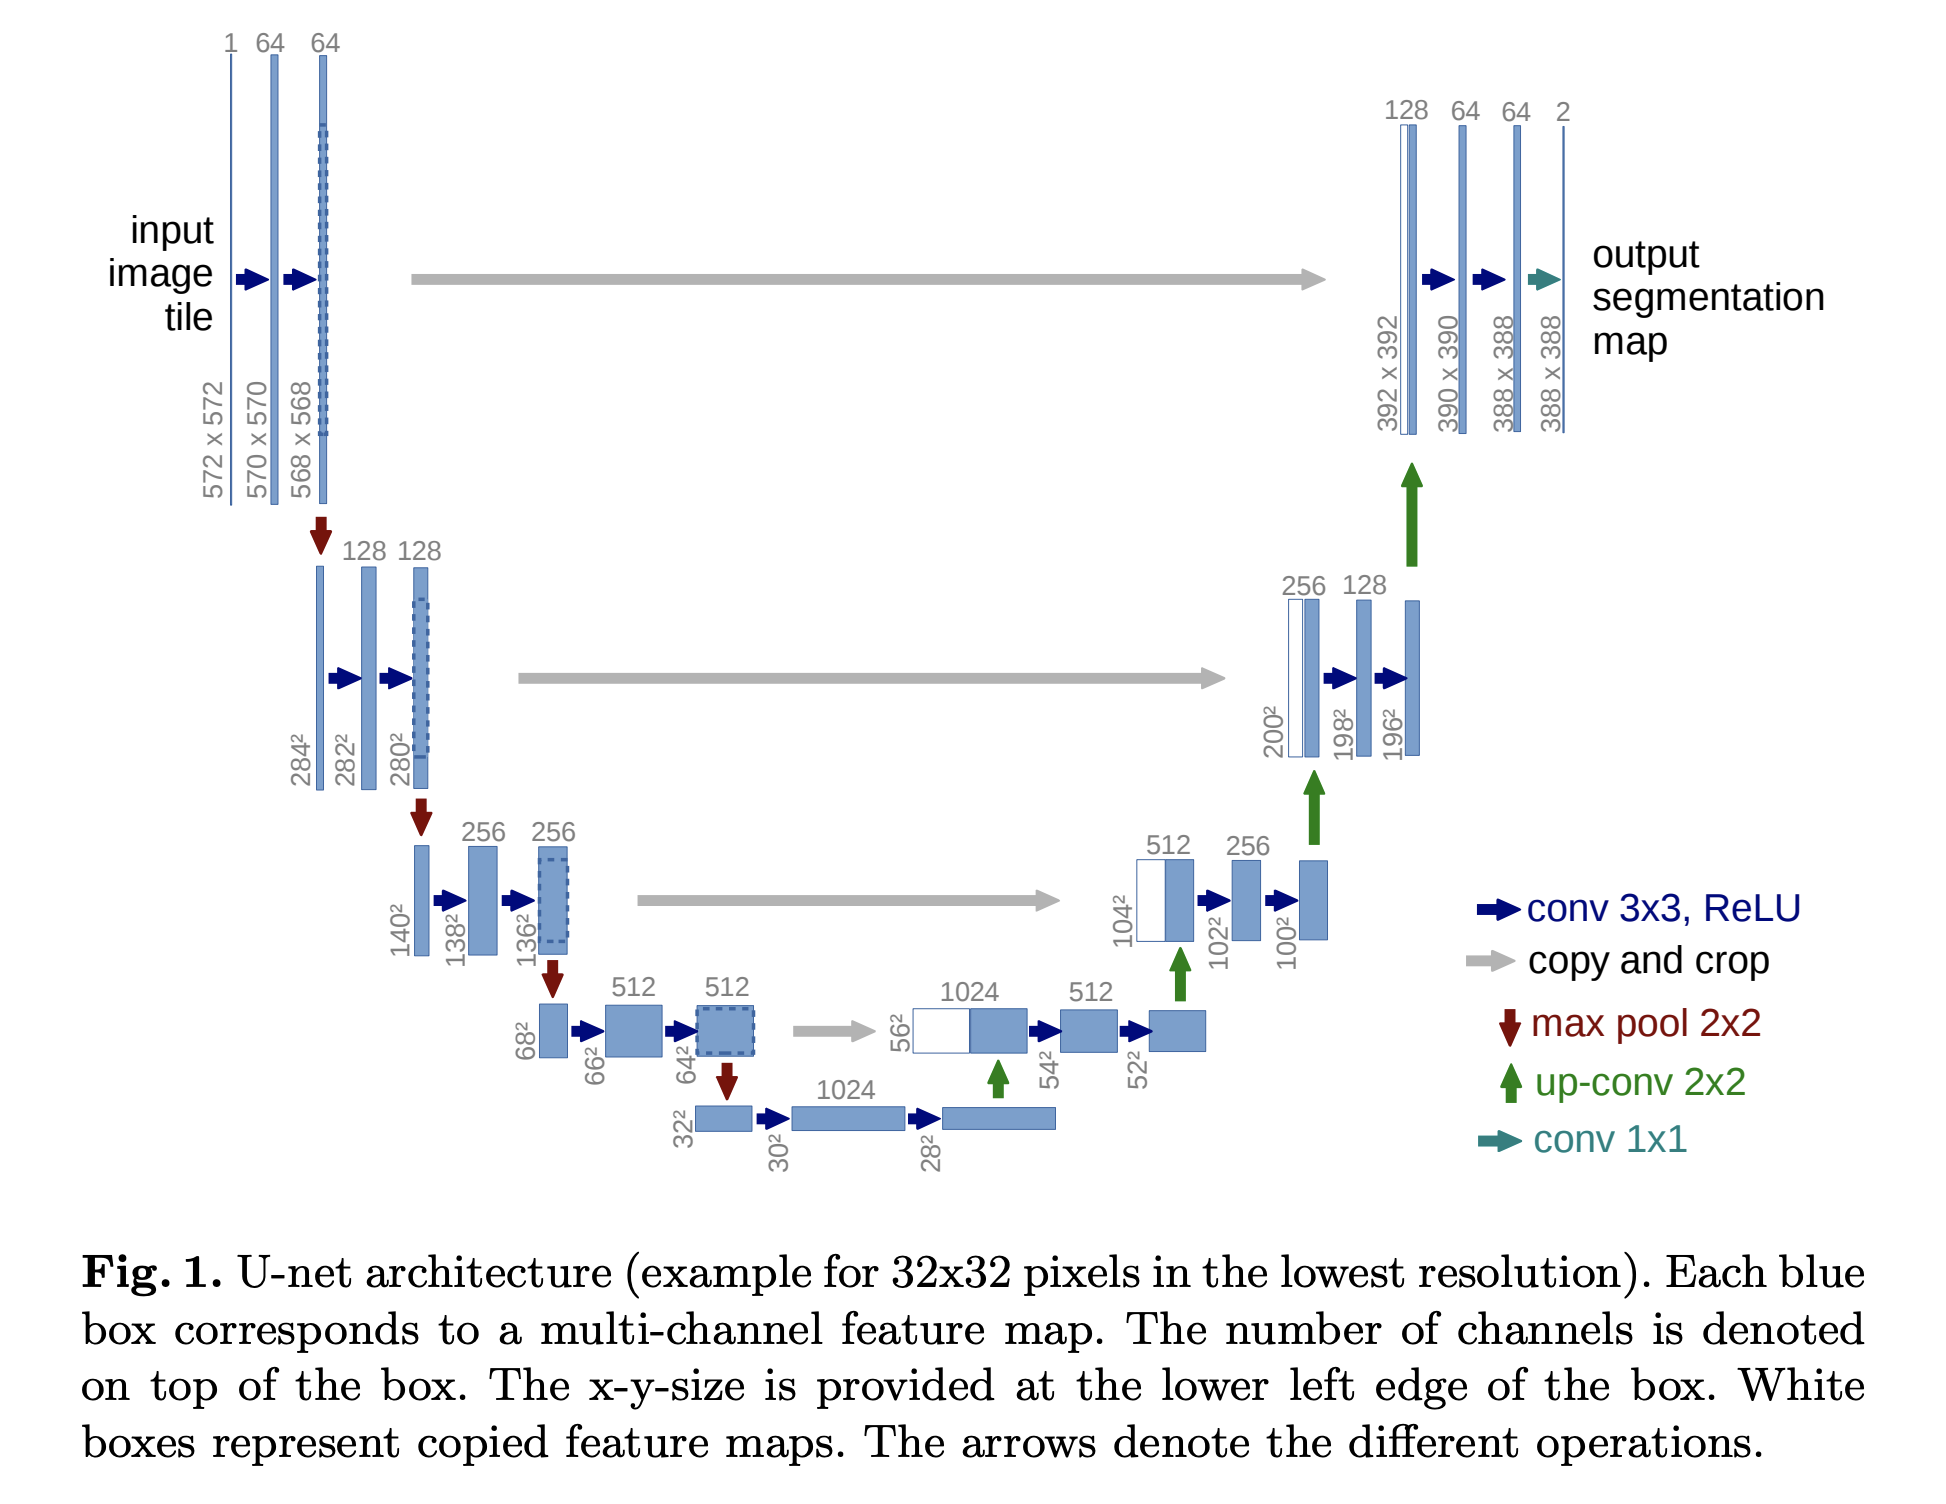

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно. Возможно, вам будет полезно вывести архитектуру модели `VGG` и изучить параметры слоев pooling.

При реализации `Decoder` вам пригодится интерполяция, для этого можно использовать `torch.nn.functional.interpolate` с `mode=nearest`.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [39]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks

        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features

        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(0, 4 * num_blocks, 4 + 1):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            self.blocks.append(
                feature_extractor[idx: idx + 4]
            )

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            # your code here
            x = block(x)

            # Сохраните активации для передачи их в декодер
            # your code here
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            # your code here
            x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        return activations

In [24]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:02<00:00, 239MB/s]


#### `Decoder`

In [38]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()

    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here

        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here


        # Две свёртки с ReLu
        # your code here
        down = torch.nn.functional.interpolate(down, scale_factor=2, mode="nearest")
        down = self.upconv(down)
        x = torch.cat((down, left), dim = 1)

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x


In [37]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1] #последний слой энкодера
        for block, left in zip(self.blocks, acts[-2::-1]): #acts[-2::-1]
            up = block(up, left)
        return up

#### `U-Net`

In [36]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)

        # your code here
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks-1)

        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    def forward(self, x):
        # your code here
        activations = self.encoder.forward(x)
        x = self.decoder.forward(activations)
        x = self.final(x)
        return x

In [28]:
model = UNet(num_classes=1, num_blocks=3)
sum((param.numel() for param in model.parameters()))

2067649

In [29]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
      )
      (2): Sequential(
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

Учтите, что знаменатель может быть равен нулю, например, если маска нулевая. Такие объекты можно не учитывать при агрегации и пропускать, так как в ином случае подсчет метрики на всем батче будет NaN. В pytorch есть встроенные для этого функции с префиксом nan.


In [26]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:

            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed.
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()

        self.threshold = threshold
        self.reduction = reduction

    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        predicted_labels = (logits > self.threshold).float()
        intersection = torch.sum(predicted_labels * true_labels, dim=(1, 2))
        union = torch.sum(predicted_labels + true_labels, dim=(1, 2)) - intersection
        score = torch.where(union != 0, intersection / union, torch.nan)

        if self.reduction == 'sum':
            return torch.nansum(score)
        elif self.reduction == 'mean':
            return torch.nanmean(score)
        return score

In [31]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

In [32]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)

# wandb

In [27]:
import plotly.express as px


@torch.no_grad()
def eval_net(net, test_dataloader, IoU, Dice, device, threshold):
    net.eval()
    mean_IoU = 0.0
    mean_Dice = 0.0
    num_c = 0

    for image, mask in test_dataloader:
        image, mask = image.to(device), mask.to(device)
        logits = (net(image) > threshold).float()

        batch_size = logits.shape[0]
        mean_IoU += IoU(logits, mask).item() * batch_size
        mean_Dice += Dice(logits, mask).item() * batch_size
        num_c += batch_size
    return mean_IoU / num_c, mean_Dice / num_c

@torch.no_grad()
def plot_wandb(net, run, valid_dataloader, device, threshold, IoU):
    _image, _mask = next(iter(valid_dataloader))
    batch_image = _image[:4,:,:,:]
    batch_mask = _mask[:4,:,:,:]
    batch_image = batch_image.to(device)

    Denormalize = Denormalize_batch()
    pred_mask = net(batch_image)
    pred_mask = (pred_mask > threshold).float()

    batch_image = Denormalize(batch_image)
    examples = []
    def tensor_to_numpy(tensor):
        return tensor.cpu().numpy().transpose(1, 2, 0)

    for i in range(4):
        ious = IoU(pred_mask[i].cpu().unsqueeze(0), batch_mask[i].unsqueeze(0))
        image = tensor_to_numpy(batch_image[i])
        mask = tensor_to_numpy(batch_mask[i])
        pred = tensor_to_numpy(pred_mask[i])

        image_wandb = wandb.Image(image, caption=f"Image {i + 1}", )
        mask_wandb = wandb.Image(mask, caption=f"Mask {i + 1}")
        pred_wandb = wandb.Image(pred, caption=f"Predicted Mask {i + 1} \n\IoU: {ious}")

        examples.append(image_wandb)
        examples.append(mask_wandb)
        examples.append(pred_wandb)

    wandb.log({"Images/image": examples})

@torch.no_grad()
def log_gradients(model, global_step, log_norm=True, log_hist=True):
    for name_param, param in model.named_parameters():
        g = param.grad
        if g is None:
            continue

        if log_hist:
            wandb.log({f"grad/{name_param}": wandb.Histogram(g.cpu())}, global_step)

        if log_norm:
            wandb.log({f"grad_norm/{name_param}": torch.norm(g.cpu())}, global_step)


@torch.no_grad()
def log_weights(model, global_step, log_norm=True, log_hist=True):
    for name_param, param in model.named_parameters():
        if param is None:
            continue

        if log_hist:
            wandb.log({f"weights/{name_param}": wandb.Histogram(param.cpu())}, global_step)

        if log_norm:
            wandb.log({f"weights_norm/{name_param}": torch.norm(param.cpu())}, global_step)

activations = dict()
gradients = dict()
hook_forward_count = 0
hook_backward_count = 0
def hook_fn(module, input, output):
    global hook_forward_count
    layer_name = module.__class__.__name__

    activations[layer_name + str(hook_forward_count)] = output.detach()
    hook_forward_count += 1

def backward_hook(module, grad_in, grad_out):
    global hook_backward_count
    layer_name = module.__class__.__name__
    gradients[layer_name + str(hook_backward_count)] = grad_out[0].detach()
    hook_backward_count += 1

def activations_viz(run, activations, num_samples=4):
    def tensor_to_numpy(tensor):
        return tensor.cpu().numpy().transpose(1, 2, 0)
    for name, act in activations.items():
        act = activations[name][:4, :, :, :]
        act = torch.mean(act, dim=1, keepdim=True)
        examples = []
        for i in range(num_samples):
            img = tensor_to_numpy(act[i])

            plt.imshow(img, cmap='jet')
            plt.axis('off')
            plt.tight_layout()
            plt.draw()

            img = np.array(plt.gcf().canvas.renderer.buffer_rgba())
            plt.close()

            act_wandb = wandb.Image(img, caption=f"Activation {i}")
            examples.append(act_wandb)

        wandb.log({f"Activations/{name}": examples})

def log_activation_gradients(run, gradients, num_samples=4):
    for name, grad_relu in gradients.items():
        for i in range(num_samples):

            if len(grad_relu.shape) == 4:
                avg_relu = torch.mean(grad_relu[i], dim = 0, keepdim = True)
                fig, axes = plt.subplots()
                axes.imshow(avg_relu.cpu().numpy().transpose(1, 2, 0), cmap = "viridis")
                axes.set_axis_off()
                axes.set_title(f"gradient of Loss by {name}, img {i}")
                wandb.log({f"grad_activation/{name}_img_{i}": wandb.Image(fig)})
                plt.close(fig)


# Обучение

In [35]:
# import time
# from tqdm import tqdm
# from torch.utils.tensorboard import SummaryWriter
# import gc
# import tensorflow as tf
# class GarbageCollectorCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         gc.collect()
# trash = GarbageCollectorCallback()

In [44]:
torch.cuda.empty_cache()
wandb.finish()
activations.clear()
hook_forward_count = 0
hook_backward_count = 0

def train(iters_num, net, optimizer_wrapper, criterion_fn, train_dataloader, valid_dataloader, device, threshold, IoU, config, hook_handles):
    timestamp = time.strftime("%Y%m%d-%H%M%S")


    run = wandb.init(project=f"Unet", config=config, name=config['name'], save_code=True, sync_tensorboard=True)
    wandb.run.log_code(
        "./",
        include_fn=lambda path: path.endswith(".ipynb")
    )
    net = net.to(device)
    # input_x = torch.randn(1, *train_dataloader.dataset[0][0].shape).to(device)
    # writer = SummaryWriter(log_dir=f"runs/{config['name']}")
    # writer.add_graph(net, input_x)

    hook_handles = [] # для удаления хуков

    for hook in hook_handles:
        hook.remove()
    hook_handles.clear()

    for i, block in enumerate(net.encoder.blocks):
        for j, layer in enumerate(block):
            if isinstance(layer, torch.nn.ReLU):
                hook = layer.register_forward_hook(hook_fn)
                hook_handles.append(hook)
    for i, block in enumerate(net.encoder.blocks):
        for j, layer in enumerate(block):
            if isinstance(layer, torch.nn.ReLU):
                hook = layer.register_backward_hook(backward_hook)
                hook_handles.append(hook)
    global_step = 0

    Dice = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)

    for epoch in range(1, iters_num + 1):
        net.train()
        for image, mask in tqdm(train_dataloader, desc=f"Эпоха {epoch}", ncols = 100):
            optimizer_wrapper.zero_grad()
            image, mask = image.to(device), mask.to(device)


            logits = net(image)
            loss = criterion_fn(logits, mask)

            loss.backward()
            optimizer_wrapper.step()

            mask_pred = (logits > threshold).float()
            wandb.log({
                'train/IoU': IoU(mask_pred, mask),
                'train/Loss': loss.item(),
            })

        activations_viz(run, activations)
        # log_activation_gradients(run, gradients, num_samples=4)


        hook_forward_count = 0
        hook_backward_count = 0

        plot_wandb(net, run, valid_dataloader, device, threshold, IoU)
        log_gradients(net, global_step, log_norm=True, log_hist=True)
        log_weights(net, global_step, log_norm=True, log_hist=True)

        # IoU_test, Loss_test = eval_net(net, valid_dataloader, IoU, Dice, device, threshold)
        # wandb.log({
        #     'eval/IoU': IoU_mean_test,
        #     'eval/Loss': Loss_test,
        # })
        # plot_wandb(net, run, valid_dataloader, device)
        global_step += 1
    for hook in hook_handles:
        hook.remove()

    activations.clear()
    gradients.clear()
    hook_handles.clear()
    wandb.finish()

    # writer.close()

net = UNet(num_classes = 1, num_blocks = 4)
lr = 1e-4
optim = torch.optim.Adam(params = net.parameters(), lr=lr)
criterion_fn = DiceLoss(reduction='mean', with_logits=True)
threshold = 0.5
IoU = IoUScore(threshold, 'mean')


iters_num = 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

hook_handles = []

config = {
    'name': "Unet",
    "Loss": criterion_fn,
    "threshold": threshold,
    "Eval": "IoU",
    "otim": "Adam",
    "epoch_num": iters_num,
    "lr": lr,
    "batch_size": 8,
    "blocks": 4,
}

print(device)

cuda:0


In [29]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=2)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=2, shuffle=True)

In [28]:
import time
from tqdm import tqdm

In [46]:
train(
    iters_num=iters_num,
    net = net,
    optimizer_wrapper=optim,
    criterion_fn = criterion_fn,
    train_dataloader=train_data_loader,
    valid_dataloader=test_data_loader,
    device=device,
    threshold=threshold,
    IoU=IoU,
    config = config,
    hook_handles = hook_handles,
)

Эпоха 1:   0%|                                                              | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Эпоха 1:   4%|██▏                                                   | 7/169 [00:51<19:50,  7.35s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 60.12 MiB is free. Process 43237 has 14.68 GiB memory in use. Of the allocated memory 14.20 GiB is allocated by PyTorch, and 366.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [45]:
torch.cuda.empty_cache()
wandb.finish()
activations.clear()
gradients.clear()
hook_forward_count = 0
hook_backward_count = 0
for hook in hook_handles:
        hook.remove()
hook_handles.clear()

In [ ]:
#______________-------------------______________ осталось (распредлеение активаций,)

### `Логирование`

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html) или с помощью модуля [wandb](https://docs.wandb.ai/tutorials/) вам предлагается самим выбрать более удобный для вас модуль.

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска.

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной фигуре [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure), [реализация через Wandb](https://docs.wandb.ai/guides/track/log/plots/#matplotlib-and-plotly-plots) (лучше делать через fig и Image). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. Гиперпараметры модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams), [реализация через Wandb](https://docs.wandb.ai/guides/track/config/)
5. Структуру модели [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph), **про реализацию wandb ниже**

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. Распределение весов, активаций, градиентов [реализация через Tensorboard](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram), [реализация через Wandb](https://docs.wandb.ai/ref/python/data-types/histogram/). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи.
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook) (данный хук не работает с inplace операциями, например, с `torch.nn.ReLU(inplace=True)`. Или не используйте inplace операции, или используйте [`Tensor.register_hook`](https://github.com/pytorch/pytorch/issues/61519)), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

#### `Некоторые советы по wandb`

- При логировании всегда указывайте параметр step, который должен не уменьшаться.

- При логировании изображений лучше их нормировать в диапазон [0, 1] как в функции `show_idx_image` выше. Для логирования предсказаний маски, лучше использовать вероятности. При неправильном диапозоне изображения могут отображаться неверно!

- Вместо логирования изображений, лучше логировать `matplotlib` графики и соответсвующие им `figure`. Кроме того, лучше закрывать все открытые графики, чтобы не перегружать ноутбук. Пример кода:


```python
fig, ax = plt.subplots(...)
...
wandb.log({key: wandb.Image(fig)}, step=global_step)
plt.close('all')
```

- Функционал построение bins в `wandb.Histogram` ограничен, можете посмотреть в сторону аргумента `np_histogram`.

- Wandb не имеет широкого функционала для логирования структуры модели. Есть способ через wandb.watch(net, log_graph=True), но получаемый результаты сильно отличаются от возможностей `tensorboard`. К счастью, `wandb` умеет синхронизировать логи с `Tensorboard` поэтому можно использовать следующую логику:


```python
wandb.init(
    project=project_name,
    name=run_name,
    config=config,
    sync_tensorboard=True        # Синхронизация с tensorboard
)

writer = SummaryWriter(run_name) # Создание логера tensorboard

# Логирование графа модели
writer.add_graph(net, input_x)
writer.close()

train_loop(...)
wandb.finish()
```

- `wandb` по умолчанию сохраняет все логи локально и на сайте в вашем личном хранилище. В случае перезагрузки `Google Colab` локальные файлы не сохраняются! Кроме того, скачивание файлов не через GoogleDisk достаточно продолжительное (в районе 20-30 минут).

- В `wandb` можно легко сохранять код и указать директорию, так вы никогда не забудете какой именно код получает результаты логов.

```python
wandb.init(..., settings=wandb.Settings(code_dir="."))
```

Кроме того, можно сохранить отдельные файлы:

```python
wandb.init(..., save_code=True)
wandb.run.log_code(
    "./",
    include_fn=lambda path: condition(path)
)
```

- В `wandb` есть функция для автоматического логирования весов и градиентов модели `wandb.watch()`, но функционал слишком ограничен и накладывает слишком много накладных расходов. **Лучше писать руками!**

#### `Некоторые советы по tensorboard`

- Функционал и возможности `tensorboard` шире (работа с 3D, продвинутые визуализации).

- `tensorboard` сохраняет логи только локально, то есть после закрытия `Google Colab` ничего не сохранится. В реальных проектах это является сильной стороной, так как гарантирует безопасность и конфиденциальность.

- Для визуализации логов достаточно запустить в ноутбуке или в терминале соответсвующее расширение, однако в случае `Google Colab` для этого приходится прокидывать порты, [подробнее тут](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).

- `tensorboard` меньше лагает и более легковесный.


### `Некоторые советы по логированию`

- Вы можете выбрать либо `wandb`, либо `tensorboard`.

- В реальных проектах лучше добавить логирование кода с целью сохранения и воспроизводимости результатов.

- Называйте запуски осмысленно, чтобы по названию можно было понять смысл запуска и варьеруемые параметры.


### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [ ]:
# your code here


## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections (сложения). Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

*Подсказка:* так как конкатенации слоёв заменили на skip-connections, то ожидается, что число параметров стало меньше.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [30]:
# your code here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg13, VGG13_Weights

class LinkNetEncoder(nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        feature_extractor = vgg13(weights=weights).features
        self.blocks = nn.ModuleList()
        for idx in range(0, 4 * num_blocks, 4 + 1):
            self.blocks.append(feature_extractor[idx: idx + 4])

    def forward(self, x):
        activations = []
        for block in self.blocks:
            x = block(x)
            activations.append(x)
            x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        return activations

class ResidualDecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
    def forward(self, down, left):
        # your code here
        down = torch.nn.functional.interpolate(down, scale_factor=2, mode="nearest")
        down = self.upconv(down)
        # x = torch.cat((down, left), dim = 1)
        x = down + left

        # x = self.conv2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class LinkNetDecoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, ResidualDecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1] #последний слой энкодера
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

class LinkNet(nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        self.encoder = LinkNetEncoder(num_blocks=num_blocks)
        self.decoder = LinkNetDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        activations = self.encoder(x)
        x = self.decoder.forward(activations)
        x = self.final(x)
        return x


In [31]:
torch.cuda.empty_cache()
wandb.finish()
activations.clear()
hook_forward_count = 0
hook_backward_count = 0

def train(iters_num, net, optimizer_wrapper, criterion_fn, train_dataloader, valid_dataloader, device, threshold, IoU, config):
    timestamp = time.strftime("%Y%m%d-%H%M%S")


    run = wandb.init(project=f"LinkNet", config=config, name=config['name'], save_code=True, sync_tensorboard=True)
    wandb.run.log_code(
        "./",
        include_fn=lambda path: path.endswith(".ipynb")
    )
    net = net.to(device)
    # input_x = torch.randn(1, *train_dataloader.dataset[0][0].shape).to(device)
    # writer = SummaryWriter(log_dir=f"runs/{config['name']}")
    # writer.add_graph(net, input_x)

    hook_handles = [] # для удаления хуков

    for hook in hook_handles:
        hook.remove()
    hook_handles.clear()

    for i, block in enumerate(net.encoder.blocks):
        for j, layer in enumerate(block):
            if isinstance(layer, torch.nn.ReLU):
                hook = layer.register_forward_hook(hook_fn)
                hook_handles.append(hook)
    for i, block in enumerate(net.encoder.blocks):
        for j, layer in enumerate(block):
            if isinstance(layer, torch.nn.ReLU):
                hook = layer.register_backward_hook(backward_hook)
                hook_handles.append(hook)
    global_step = 0

    Dice = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)

    for epoch in range(1, iters_num + 1):
        net.train()
        for image, mask in tqdm(train_dataloader, desc=f"Эпоха {epoch}", ncols = 100):
            optimizer_wrapper.zero_grad()
            image, mask = image.to(device), mask.to(device)


            logits = net(image)
            loss = criterion_fn(logits, mask)

            loss.backward()
            optimizer_wrapper.step()

            mask_pred = (logits > threshold).float()
            wandb.log({
                'train/IoU': IoU(mask_pred, mask),
                'train/Loss': loss.item(),
            })

        activations_viz(run, activations)
        log_activation_gradients(run, gradients, num_samples=4)


        hook_forward_count = 0
        hook_backward_count = 0

        plot_wandb(net, run, valid_dataloader, device, threshold, IoU)
        log_gradients(net, global_step, log_norm=True, log_hist=True)
        log_weights(net, global_step, log_norm=True, log_hist=True)
        # IoU_test, Loss_test = eval_net(net, valid_dataloader, IoU, Dice, device, threshold)
        # wandb.log({
        #     'eval/IoU': IoU_mean_test,
        #     'eval/Loss': Loss_test,
        # })
        # plot_wandb(net, run, valid_dataloader, device)
        global_step += 1
    for hook in hook_handles:
        hook.remove()

    activations.clear()
    gradients.clear()
    hook_handles.clear()
    wandb.finish()

    # writer.close()


In [32]:
net = LinkNet(num_classes = 1, num_blocks = 4)
lr = 1e-4
optim = torch.optim.Adam(params = net.parameters(), lr=lr)
criterion_fn = DiceLoss(reduction='mean', with_logits=True)
threshold = 0.5
IoU = IoUScore(threshold, 'mean')


iters_num = 2
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



config = {
    'name': "Unet",
    "Loss": criterion_fn,
    "threshold": threshold,
    "Eval": "IoU",
    "otim": "Adam",
    "epoch_num": iters_num,
    "lr": lr,
    "batch_size": 8,
    "blocks": 4,
}
train(
    iters_num=iters_num,
    net = net,
    optimizer_wrapper=optim,
    criterion_fn = criterion_fn,
    train_dataloader=train_data_loader,
    valid_dataloader=test_data_loader,
    device=device,
    threshold=threshold,
    IoU=IoU,
    config = config,
)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:02<00:00, 233MB/s]


Эпоха 1:   0%|                                                              | 0/169 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Эпоха 1:   7%|███▍                                                 | 11/169 [01:35<22:48,  8.66s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 132.12 MiB is free. Process 43237 has 14.61 GiB memory in use. Of the allocated memory 14.11 GiB is allocated by PyTorch, and 392.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.cuda.empty_cache()
wandb.finish()
activations.clear()

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей.
* Какие преимущества дает использование сверток в случае, если эти предположения верные?
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*
- Можно охватывать сразу некоторую область и можно обрабатывать объекты независимо от их расположения на картинке
- Уменьшение количества параметров
- на текстовых последовательностях может не получиться улавливать локальные зависимости, т.к важен также глобальный контекст

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$.

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации.

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите:

1. Размерность выходного пространства.
2. Количество обучаемых параметров.
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке* \\
Полносвязный слой: \\
-Размерность выходного пространства: \\
1000 \\
-Количество обучаемых параметров: \\
101000 \\
-Число операций при forward pass: \\
101000 \\


Сверточный слой: \\
-Размерность выходного пространства: \\
1000 \\
-Количество обучаемых параметров: \\
40 \\
-Число операций при forward pass: \\
4000

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```